In [1]:
# Main file for the whole workflow of this project. This file will manipulate the data,
# train/cluster features, and analyze potential results.

from data_preparation import DataHelpers, FeatureExtractor, Preprocessor, DimensionalityReducer
from data_preparation.SIFT import *
from data_preparation.HOG import *
from data_preparation.ORB import *
from data_preparation.Sklearn_PCA import *
from learning.Sklearn_SVM import *
from sklearn.metrics import accuracy_score
import sklearn

%matplotlib inline
%load_ext autoreload
%autoreload 2

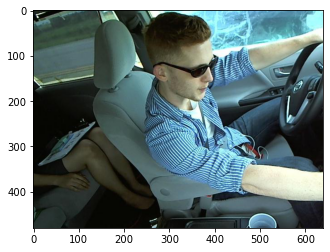

In [2]:
import matplotlib.pyplot as plt
rand_img = DataHelpers.get_random_training_image()
plt.imshow(rand_img)

(1807, 128)


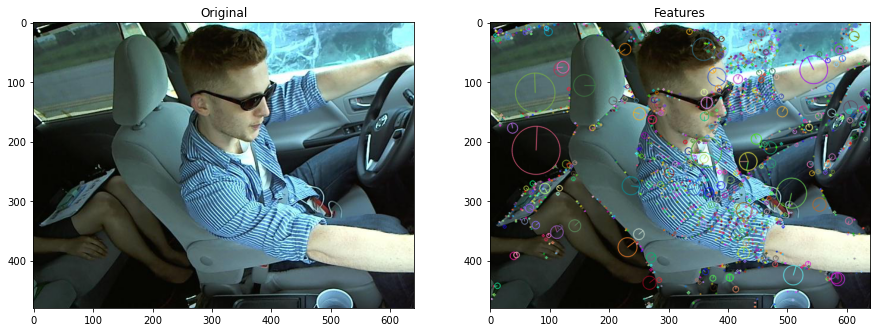

In [3]:
sift = SIFT()
image_kp, desc = sift.get_features_single(rand_img, visualize=True)
print(desc.shape)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
ax.set_title("Original")
plt.imshow(rand_img)
ax = fig.add_subplot(122)
ax.set_title("Features")
plt.imshow(image_kp)

In [93]:
def prepare_batch(data,
                  feature_extractor: FeatureExtractor = None, 
                  preprocessor: Preprocessor = None,
                  dimensionality_reducer: DimensionalityReducer = None):
    if feature_extractor:
        data = feature_extractor.get_features(data)
    if preprocessor:
        data = preprocessor.get_preprocessed_data(data)
    if dimensionality_reducer:
        data = dimensionality_reducer.get_reduced_data(data)

    return data

def prepare_batches(data_paths, 
                 labels = None,
                 feature_extractor: FeatureExtractor = None, 
                 preprocessor: Preprocessor = None,
                 dimensionality_reducer: DimensionalityReducer = None):

    num_batches = len(data_paths)
    prepared_batches = None

    for batch_i in range(num_batches):
        batch_images = DataHelpers.open_batch(data_paths[batch_i])
        prepared_batch = prepare_batch(batch_images, feature_extractor, preprocessor, dimensionality_reducer)
        if prepared_batches is None:
            prepared_batches = prepared_batch
        else:
            prepared_batches = np.vstack((prepared_batches, prepared_batch))

        if num_batches >= 10 and batch_i % (num_batches//10) == 0 and batch_i > 0:
            print(f'Batch {batch_i}/{num_batches} done preparing...')

    D = prepared_batches.shape[-1]
    data = np.concatenate(prepared_batches, axis=0).reshape((-1, D))

    if labels is not None:
        labels = np.concatenate(labels, axis=0).reshape((-1,))
        return (data, labels)
    else:
        return data

In [174]:
feature_extractor = HOG(orientations=8, pixels_per_cell=(32,32))
preprocessor = None
# dimensionality_reducer = None
# dimensionality_reducer = Sklearn_PCA(n_components=10)

NUM_BATCHES_TRAIN = 350
batches_as_paths, batches_labels = DataHelpers.generate_training_batches(NUM_BATCHES_TRAIN)

In [175]:
batch_dev, label_dev = batches_as_paths[:10], batches_labels[:10]
x_train, y_train = prepare_batches(batch_dev, label_dev, feature_extractor, preprocessor, dimensionality_reducer)

batch_test, label_test = batches_as_paths[30:35], batches_labels[30:35]
x_test, y_test = prepare_batches(batch_test, label_test, feature_extractor, preprocessor, dimensionality_reducer)
# x_train = np.array(x_train)
print(x_train.shape)
# print(x_train, y_train)

Batch 1/10 done preparing...
Batch 2/10 done preparing...
Batch 3/10 done preparing...
Batch 4/10 done preparing...
Batch 5/10 done preparing...
Batch 6/10 done preparing...
Batch 7/10 done preparing...
Batch 8/10 done preparing...
Batch 9/10 done preparing...
(640, 10)


In [167]:
y_train_bin = [0 if y < 4 else 1 for y in y_train]
y_test_bin = [0 if y < 4 else 1 for y in y_test]

print(y_train)
print(y_test)

[4 7 8 4 5 3 7 1 0 0 4 7 3 0 5 1 0 1 8 3 0 0 0 0 4 7 9 6 3 8 7 6 8 0 0 5 3
 8 0 0 6 1 3 3 4 3 4 1 0 1 5 3 4 5 0 2 3 9 8 8 4 1 6 9 9 9 6 2 0 5 5 3 2 6
 8 9 5 2 2 4 6 2 6 5 6 0 9 3 7 7 4 5 5 8 7 1 2 4 3 6 2 2 9 0 9 0 5 5 2 5 8
 9]
[9 0 5 9 1 8 7 7 7 6 0 4 8 7 2 6 9 7 1 7 1 9 4 6 5 0 2 7 6 8 5 4 6 8 4 9 9
 4 4 7 9 8 5 2 4 5 6 3 1 1 6 9 0 0 7 4 1 1 9 6 9 1 0 1 0 2 7 8 2 0 2 5 5 2
 6 5 0 1 5 6 8 4 7 4 3 3 4 8 0 8 6 6 5 5 9 3 4 5 2 3 0 5 8 1 0 1 0 0 5 2 8
 2]


In [176]:
# model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
model = sklearn.svm.SVC(kernel="linear")
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
y_pred = model.predict(x_test)
print(y_pred)
print(y_test)
print(score)

[1 4 2 3 1 7 4 2 7 0 4 5 2 8 3 4 3 3 1 1 2 2 3 3 9 4 5 4 4 1 3 4 2 0 6 6 3
 1 1 6 0 3 6 6 4 3 6 7 0 6 2 4 4 6 1 6 7 5 4 7 8 2 7 3 6 3 0 9 2 1 9 6 9 3
 3 5 3 3 7 6 6 5 1 3 4 0 6 2 9 4 4 1 4 3 2 0 0 9 3 3 7 2 4 5 3 6 6 3 6 1 1
 5 7 3 3 3 7 1 5 5 6 9 3 5 4 4 7 7 3 5 2 2 5 1 6 5 1 0 6 0 0 4 2 4 2 3 3 3
 3 1 2 4 5 7 2 3 4 1 0 2 9 2 3 4 6 3 1 4 2 3 0 3 3 3 5 1 6 1 6 9 4 3 8 5 6
 0 3 4 6 2 3 4 6 6 4 0 4 4 7 3 4 4 5 2 2 4 2 1 0 9 1 3 4 9 2 4 1 2 7 3 2 7
 3 6 2 4 4 3 3 3 3 3 4 9 1 9 1 2 3 4 3 9 3 2 5 9 5 3 4 3 6 3 2 4 3 0 1 6 3
 7 9 0 6 3 3 4 1 1 1 5 3 3 7 4 1 1 3 3 5 6 1 6 3 1 0 1 9 2 0 0 2 2 1 3 4 5
 3 9 2 2 3 3 2 9 4 9 2 5 7 3 7 7 6 3 3 9 4 3 5 6]
[4 0 2 6 7 5 0 5 3 9 2 7 3 8 6 5 3 5 1 5 1 7 9 2 6 2 8 5 2 3 2 0 2 7 6 4 8
 0 5 2 3 8 1 1 6 6 5 4 3 2 7 7 8 7 6 4 5 3 9 8 9 5 3 9 6 4 9 5 0 0 9 9 0 3
 3 0 5 5 6 7 2 5 4 4 0 7 2 1 7 4 0 5 4 3 5 9 3 3 8 6 4 6 3 1 3 6 5 0 2 7 3
 0 2 3 2 3 6 5 4 7 2 7 2 8 8 1 6 6 4 7 1 8 7 2 5 2 4 8 2 3 0 8 1 3 0 3 3 5
 4 4 8 9 5 9 0 1 2 6 1 6 8 8 3 1 5 0 3 2 4 0 1 3 9

In [125]:
classifier = Sklearn_SVM()
classifier.train(x_train, y_train)

In [126]:
y_prob = classifier.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
print(x_test)
print(y_pred)
print(y_test)
print(accuracy_score(y_test, y_pred))

[[ 4  5 12 ... 14  6  7]
 [ 3  7 15 ...  5  2 12]
 [ 0 13  9 ...  8  3  1]
 ...
 [ 6  4  2 ...  7  3  1]
 [ 7  1  2 ...  9  8  3]
 [ 1  2  7 ...  7  9  3]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 5 0 0 0 0 0 0
 2 0 0 0 0 0 2 0 0 2 0 0 0 5 2 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0
 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 2 0 0 0 2 0
 0]
[1 8 8 2 1 7 9 0 6 3 8 4 4 6 7 2 4 5 0 4 2 5 0 3 8 7 0 2 6 0 5 5 2 6 1 5 4
 9 4 1 3 0 6 4 9 0 2 5 0 1 1 6 4 0 2 0 8 7 9 1 3 4 9 6 6 7 4 5 3 5 0 4 9 4
 1 1 3 7 0 0 3 6 8 6 9 2 2 2 8 0 8 7 6 9 6 8 0 8 3 6 6 2 4 6 4 9 2 6 6 2 3
 3]
0.13392857142857142


In [ ]:
feature_extractor = SIFT()
preprocessor = None
dimensionality_reducer = None
# dimensionality_reducer = Sklearn_PCA(n_components=50)

print("begin training")
TRAINING_NEW_CLASSIFIER = True
if TRAINING_NEW_CLASSIFIER:
    classifier = Sklearn_SVM()

    NUM_BATCHES_TRAIN = 350
    batches_as_paths, batches_labels = DataHelpers.generate_training_batches(NUM_BATCHES_TRAIN)
    x_train, y_train = prepare_batches(batches_as_paths, batches_labels, feature_extractor, preprocessor, dimensionality_reducer)
    classifier.train(x_train, y_train)
    DataHelpers.save_model(classifier, 'sift_svm')
else:
    classifier = DataHelpers.load_model('sift_svm')

print("begin testing")
NUM_BATCHES_TEST = 350
x_test_names, x_test_paths = DataHelpers.generate_testing_batches(NUM_BATCHES_TEST)
prepared_test = prepare_batches(x_test_paths, None, feature_extractor, preprocessor, dimensionality_reducer)
# print(prepared_test.shape)

y_pred = classifier.predict(prepared_test)

x_test_names = np.concatenate(x_test_names, axis=0).reshape((-1,))
DataHelpers.output_to_csv('Sklearn_SVM', x_test_names, y_pred)

print('DONE!')

begin training
Batch 35/350 done preparing...
Batch 70/350 done preparing...
Batch 105/350 done preparing...
Batch 140/350 done preparing...
Batch 175/350 done preparing...
Batch 210/350 done preparing...
Batch 245/350 done preparing...
Batch 280/350 done preparing...
Batch 315/350 done preparing...


In [ ]:
print(x_train.shape)